In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime as dt

import os

start = "2010-01-01"                    # string is fine, pandas will parse it
end = dt.date.today().isoformat()       # today's date as 'YYYY-MM-DD'
print(start, end)                       # define data range


2010-01-01 2025-11-28


## Download SPY data

In [2]:
if not os.path.exists("datasets/spy/spy_2010_2025.csv"):
    spy = yf.download("SPY", start=start, end=end, group_by=None, auto_adjust=False) # sends a request to Yahoo for that ticker
    spy.columns = ['_'.join(c.replace(" ", "_") for c in col) if isinstance(col, tuple) else col.replace(" ", "_") for col in spy.columns] # Flatten multi-index: join levels with underscore
    spy.to_csv("datasets/spy/spy_2010_2025.csv") # Save to local file
else:
    spy = pd.read_csv("datasets/spy/spy_2010_2025.csv", parse_dates=["Date"], index_col="Date")
print(spy.head())

              SPY_Open    SPY_High     SPY_Low   SPY_Close  SPY_Adj_Close  \
Date                                                                        
2010-01-04  112.370003  113.389999  111.510002  113.330002      85.279213   
2010-01-05  113.260002  113.680000  112.849998  113.629997      85.504951   
2010-01-06  113.519997  113.989998  113.430000  113.709999      85.565117   
2010-01-07  113.500000  114.330002  113.180000  114.190002      85.926361   
2010-01-08  113.889999  114.620003  113.660004  114.570000      86.212296   

             SPY_Volume  
Date                     
2010-01-04  118944600.0  
2010-01-05  111579900.0  
2010-01-06  116074400.0  
2010-01-07  131091100.0  
2010-01-08  126402800.0  


## Later: load existing data

parse_dates=["Date"]: tells pandas: “this column is a date, not just a string”

index_col="Date": use the Date column as the index (so we can treat it like a time series)

In [3]:
spy_old = pd.read_csv("datasets/spy/spy_2010_2025.csv", parse_dates=["Date"], index_col="Date")
spy_old.tail()


,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Adj_Close,SPY_Volume
Date,,,,,,
2025-11-20,672.909973,675.559998,651.890015,652.530029,652.530029,165293500.0
2025-11-21,655.049988,664.549988,650.849976,659.030029,659.030029,123956200.0
2025-11-24,662.690002,670.059998,661.590027,668.729980,668.729980,80437900.0
2025-11-25,668.630005,676.210022,664.479980,675.020020,675.020020,81077100.0
2025-11-26,677.630005,681.700012,676.719971,679.679993,679.679993,71879600.0


### Find the last date and download only new data

Last date in local file: 2025-11-26 00:00:00


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-11-27 -> 2025-11-28)')


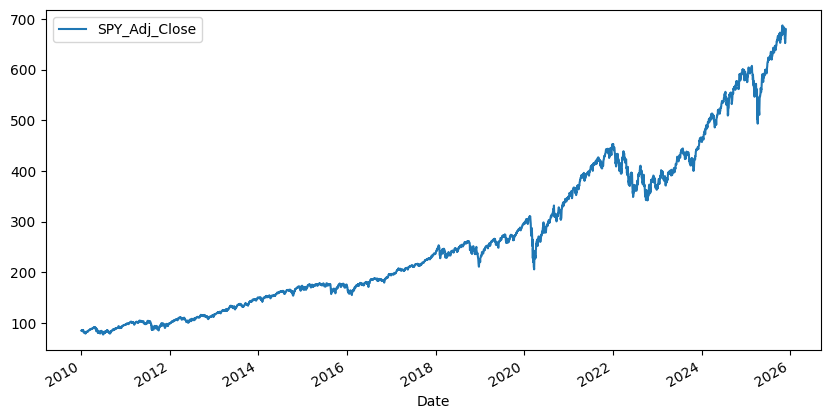

In [4]:
last_date = spy_old.index.max()
print("Last date in local file:", last_date)

# Define new start date as last_date + 1 day
next_start = (last_date + pd.Timedelta(days=1)).date().isoformat()
end = dt.date.today().isoformat()
print("Downloading from", next_start, "to", end)

# Download new data
spy_new = yf.download("SPY", start=next_start, end=end, group_by=None, auto_adjust=False)
spy_new.columns = ['_'.join(c.replace(" ", "_") for c in col) if isinstance(col, tuple) else col.replace(" ", "_") for col in spy_new.columns]
spy_new.head()

# Combine old and new data
spy = pd.concat([spy_old, spy_new])
spy.to_csv("datasets/spy/spy_2010_2025.csv")

spy.tail()

spy.plot(y="SPY_Adj_Close", use_index=True, figsize=(10, 5))
plt.show()  

## Finance Basics 

### Log Return

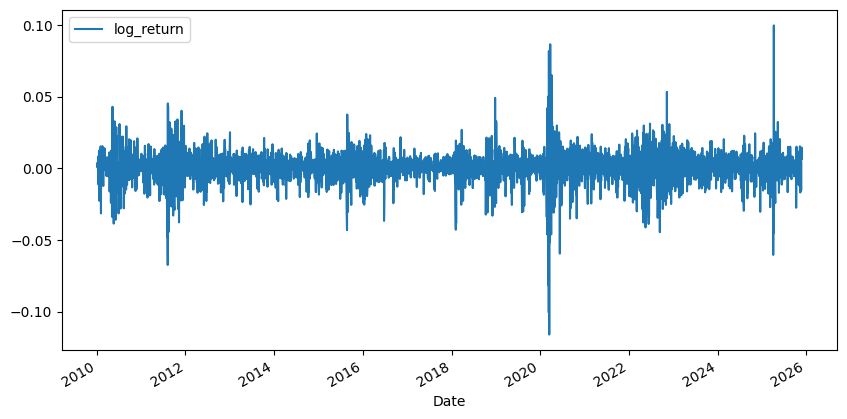

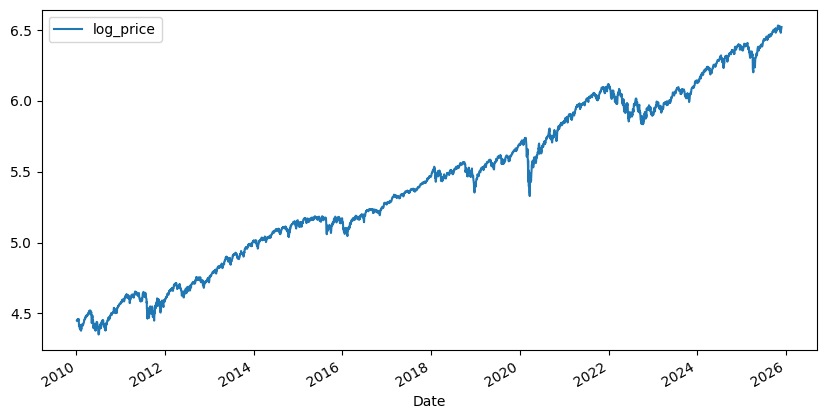

In [5]:
spy["log_price"] = np.log(spy["SPY_Adj_Close"])
spy["log_return"] = spy["log_price"] - spy["log_price"].shift(1) # Can also use spy["log_price"].diff()
spy.dropna(inplace=True) # Drop the first row where log_return is NaN
spy.head()
spy.plot(y="log_return", use_index=True, figsize=(10, 5))
spy.plot(y="log_price", use_index=True, figsize=(10, 5))
plt.show() 


### Realized Volatility (Squared Returns)

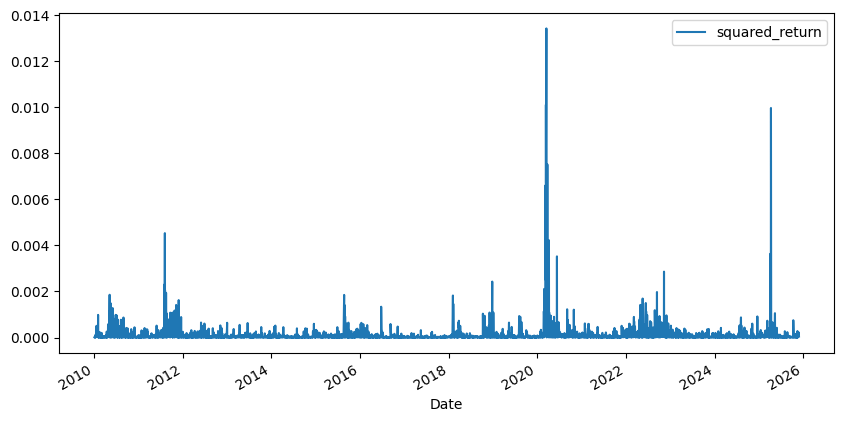

In [ ]:
spy["squared_return"] = spy["log_return"]**2 # Squared returns
spy.plot(y="squared_return", use_index=True, figsize=(10, 5))
plt.show() 


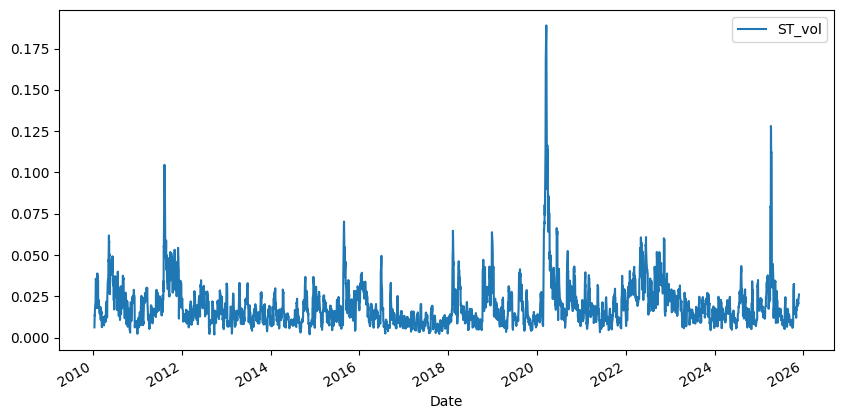

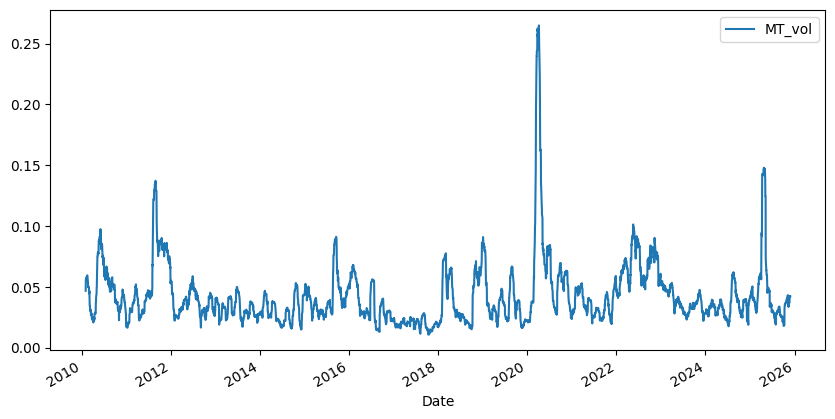

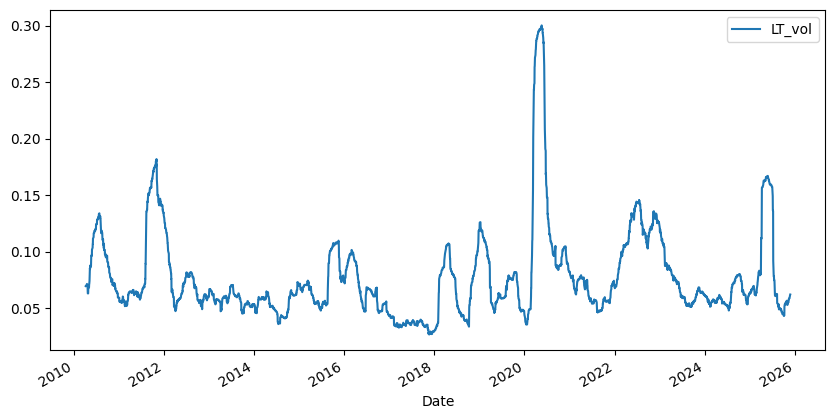

In [9]:
### Realized Volatility ST(Short-Term) Volatility (5-21 days)
#### Average of Squared Returns
spy["ST_vol"] = spy["squared_return"].rolling(window=5).sum().pow(0.5)
spy.plot(y="ST_vol", use_index=True, figsize=(10, 5))
plt.show() 

### Realized Volatility MT(Mid-Term) Volatility (21-63 days)
spy["MT_vol"] = spy["squared_return"].rolling(window=21).sum().pow(0.5)
spy.plot(y="MT_vol", use_index=True, figsize=(10, 5))
plt.show() 

### Realized Volatility LT(Long-Term) Volatility (63-126 days)
spy["LT_vol"] = spy["squared_return"].rolling(window=63).sum().pow(0.5)
spy.plot(y="LT_vol", use_index=True, figsize=(10, 5))
plt.show() 